## Mobile Payments Fraud Detection Using Arificial Neural Networks

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import clone_model
print(tf.__version__)

2.0.0


In [2]:
import pandas as pd
import numpy as np
from matplotlib import style
style.use('ggplot') # optional dark_background for dark theme
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [3]:
def plot_learningCurve(history, epoch, metric='binary_accuracy'):
    metric_title = metric.replace('_',' ').title()
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history[metric])
    plt.plot(epoch_range, history.history['val_'+metric])
    plt.title('Model '+metric_title)
    plt.ylabel(metric_title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [4]:
from sklearn.metrics import confusion_matrix
def print_confusion_matrix(testset,predictions):
    conmat=pd.DataFrame(confusion_matrix(testset, predictions, labels=[1,0]),
                        index=['Actual Fraud','Actual Non-Fraud'],
                        columns=['Pred Fraud','Pred Non-Fraud'])
    TP=conmat.iloc[0,0]/(conmat.iloc[0,0]+conmat.iloc[0,1])
    FN=conmat.iloc[0,1]/(conmat.iloc[0,0]+conmat.iloc[0,1])
    TN=conmat.iloc[1,1]/(conmat.iloc[1,0]+conmat.iloc[1,1])
    FP=conmat.iloc[1,0]/(conmat.iloc[1,0]+conmat.iloc[1,1])
    print('Percent of true positives: {:.2%}'.format(TP))
    print('Percent of false negatives: {:.2%}'.format(FN))
    print('Percent of true negatives: {:.2%}'.format(TN))
    print('Percent of false positives: {:.2%}'.format(FP))
    return conmat

In [35]:
# below are some constant settings for all the models which our team experimented on
batch_bin=32
num_epochs=5
train_pct=0.8
validate_pct=0.2
learning_rate = 1e-3
loss_function='binary_crossentropy'
optimization_function='RMSProp'
metric='binary_accuracy'

### PaySim EDA

In [6]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [7]:
data.shape

(6362620, 11)

In [8]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [10]:
data[['step','type','nameOrig','nameDest','isFraud','isFlaggedFraud']].nunique()

step                  743
type                    5
nameOrig          6353307
nameDest          2722362
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [11]:
data.groupby(['type','isFraud','isFlaggedFraud'])[['isFraud']].count().rename(columns={'isFraud':'count'})

count
type     isFraud isFlaggedFraud         
CASH_IN  0       0               1399284
CASH_OUT 0       0               2233384
         1       0                  4116
DEBIT    0       0                 41432
PAYMENT  0       0               2151495
TRANSFER 0       0                528812
         1       0                  4081
                 1                    16

### Data Preprocessing

In [7]:
# one-hot encoding for the categorical 'type' variable
dummies = pd.get_dummies(data['type'])
data2 = pd.concat([data[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
                        'isFraud']],dummies],axis=1)

In [8]:
# split data 80-20 across training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(data2.loc[:,data2.columns!='isFraud'],
                                                    data2.loc[:,data2.columns=='isFraud'],
                                                    test_size=validate_pct,train_size=train_pct)

In [9]:
# rescale datasets using StandardScaler on the training datasets
standard = StandardScaler()
standard_x_train = standard.fit_transform(x_train)
standard_x_test = standard.transform(x_test)

In [10]:
# rescale datasets using MinMaxScaler on the training datasets
minmax = MinMaxScaler()
minmax_x_train = minmax.fit_transform(x_train)
minmax_x_test = minmax.transform(x_test)

In [11]:
# reset y variable to numpy array
y_train, y_test = np.array(y_train), np.array(y_test)

In [12]:
# count how many non-fraud and fraud transactions are in the test set
unique,counts = np.unique(y_test,return_counts=True)
dict(zip(unique,counts))

{0: 1270872, 1: 1652}

In [49]:
# separate the data into non-fraud and fraud dataframes
non_fraud = data2[data2['isFraud']==0]
fraud = data2[data2['isFraud']==1]

In [50]:
non_fraud.shape, fraud.shape

((6354407, 12), (8213, 12))

In [51]:
# create a test-train split for the autoencoder using only non-fraud data
x_train_ae, x_test_ae, y_train_ae, y_test_ae = train_test_split(non_fraud.loc[:,non_fraud.columns!='isFraud'],
                                                                non_fraud.loc[:,non_fraud.columns=='isFraud'],
                                                                train_size=train_pct,test_size=validate_pct)
y_train_ae=np.array(y_train_ae)
y_test_ae

,isFraud
3902442,0
1272841,0
1804262,0
2382872,0
3323463,0
6139753,0
5935941,0
1243612,0
2094247,0
6095677,0


In [52]:
# using standard scaling to rescale the datasets' independent features
standard_ae = StandardScaler()
standard_x_train_ae = standard_ae.fit_transform(x_train_ae)
standard_x_test_ae = standard_ae.transform(x_test_ae)

In [53]:
# using normalized scaling to rescale the datasets' independent features
minmax_ae = MinMaxScaler()
minmax_x_train_ae = minmax_ae.fit_transform(x_train_ae)
minamx_x_test_ae = minmax_ae.transform(x_test_ae)

In [54]:
non_fraud = non_fraud.sample(fraud.shape[0])
non_fraud.shape

(8213, 12)

In [55]:
rand_balanced_data = fraud.append(non_fraud, ignore_index=True)
rand_balanced_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,181.0,181.0,0.0,0.0,0.0,1,0,0,0,0,1
1,1,181.0,181.0,0.0,21182.0,0.0,1,0,1,0,0,0
2,1,2806.0,2806.0,0.0,0.0,0.0,1,0,0,0,0,1
3,1,2806.0,2806.0,0.0,26202.0,0.0,1,0,1,0,0,0
4,1,20128.0,20128.0,0.0,0.0,0.0,1,0,0,0,0,1


In [56]:
rand_balanced_data['isFraud'].value_counts()

1    8213
0    8213
Name: isFraud, dtype: int64

In [18]:
# create a randomly balanced datasets for training and testing the feed forward neural netowrk on
rand_x_train,rand_x_test,rand_y_train,rand_y_test=train_test_split(rand_balanced_data.loc[:,non_fraud.columns!='isFraud'],
                                                                   rand_balanced_data.loc[:,non_fraud.columns=='isFraud'],
                                                                   train_size=train_pct,test_size=validate_pct)
rand_y_train=np.array(rand_y_train)
rand_y_test=np.array(rand_y_test)

In [19]:
# rescale datasets using StandardScaler on the training datasets
rand_standard = StandardScaler()
rand_standard_x_train = standard.fit_transform(rand_x_train)
rand_standard_x_test = standard.transform(rand_x_test)

In [20]:
# rescale datasets using MinMaxScaler on the training datasets
rand_minmax = MinMaxScaler()
rand_minmax_x_train = minmax.fit_transform(rand_x_train)
rand_minmax_x_test = minmax.transform(rand_x_test)

In [21]:
# create a SMOTE balanced version of the standard training dataset
standard_smt = SMOTE()
standard_x_train_sm, standard_y_train_sm = standard_smt.fit_sample(standard_x_train,y_train)

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
np.bincount(standard_y_train_sm)

array([5083535, 5083535], dtype=int64)

In [23]:
# create a SMOTE balanced version of the standard training dataset
minmax_smt = SMOTE()
minmax_x_train_sm, minmax_y_train_sm = minmax_smt.fit_sample(minmax_x_train,y_train)

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
np.bincount(standard_y_train_sm)

array([5083535, 5083535], dtype=int64)

### Feedforward Neural Network with Standardized Imbalanced Big Dataset

In [27]:
imbalanced_ann = Sequential()

imbalanced_ann.add(InputLayer(input_shape=(11,)))
imbalanced_ann.add(Dense(64,activation='relu'))
imbalanced_ann.add(Dropout(0.2))
imbalanced_ann.add(Dense(32,activation='relu'))
imbalanced_ann.add(Dropout(0.1))
imbalanced_ann.add(Dense(1,activation='sigmoid'))

In [28]:
imbalanced_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [29]:
imbalanced_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])

In [38]:
filepath="models/imbalanced-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_imbalanced_ann = [checkpoint]

In [39]:
standard_imbalaned_ann_fit = imbalanced_ann.fit(standard_x_train,y_train,callbacks=callbacks_list_imbalanced_ann,
                                                batch_size=batch_bin,epochs=num_epochs,validation_split=validate_pct)

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/5
4071904/4072076 [============================>.] - ETA: 0s - loss: 0.0203 - binary_accuracy: 0.9976
Epoch 00001: val_binary_accuracy improved from -inf to 0.99905, saving model to models/imbalanced-ann-weights-improvement-01-1.00.hdf5
4072076/4072076 [==============================] - 464s 114us/sample - loss: 0.0203 - binary_accuracy: 0.9976 - val_loss: 0.0134 - val_binary_accuracy: 0.9991
Epoch 2/5
4072064/4072076 [============================>.] - ETA: 0s - loss: 0.0207 - binary_accuracy: 0.9978
Epoch 00002: val_binary_accuracy improved from 0.99905 to 0.99911, saving model to models/imbalanced-ann-weights-improvement-02-1.00.hdf5
4072076/4072076 [==============================] - 453s 111us/sample - loss: 0.0207 - binary_accuracy: 0.9978 - val_loss: 0.0144 - val_binary_accuracy: 0.9991
Epoch 3/5
4071968/4072076 [============================>.] - ETA: 0s - loss: 0.0226 - binary_accuracy: 0.9978- ETA: 0s - loss: 0.0226 -

In [81]:
standardized_imbalanced_y_pred = imbalanced_ann.predict_classes(standard_x_test)

In [82]:
print_confusion_matrix(y_test,standardized_imbalanced_y_pred)

Percent of true positives: 30.27%
Percent of false negatives: 69.73%
Percent of true negatives: 100.00%
Percent of false positives: 0.00%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,490,1129
Actual Non-Fraud,1,1270904


In [80]:
# save standardized imbalanced_ann model
# serialize model to JSON
with open("models/standardized_imbalaned_ann_fraud_detector.json", "w") as json_file:
    json_file.write(imbalanced_ann.to_json())
# serialize weights to HDF5
imbalanced_ann.save_weights("models/standardized_imbalaned_ann_fraud_detector.h5")

### Feedforward Neural Network with Normalized Imbalanced Big Dataset

In [75]:
filepath="models/imbalanced-minmax-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_imbalanced_ann = [checkpoint]

In [77]:
minmax_imbalanced_ann = clone_model(imbalanced_ann)
minmax_imbalanced_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])
minamx_imbalaned_ann_fit = minmax_imbalanced_ann.fit(minmax_x_train,y_train,callbacks=callbacks_list_imbalanced_ann,
                                                     batch_size=batch_bin,epochs=num_epochs,validation_split=validate_pct)

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/5
4071904/4072076 [============================>.] - ETA: 0s - loss: 0.0122 - binary_accuracy: 0.9986
Epoch 00001: val_binary_accuracy improved from -inf to 0.99871, saving model to models/imbalanced-minmax-ann-weights-improvement-01-1.00.hdf5
4072076/4072076 [==============================] - 547s 134us/sample - loss: 0.0122 - binary_accuracy: 0.9986 - val_loss: 0.0084 - val_binary_accuracy: 0.9987
Epoch 2/5
4071840/4072076 [============================>.] - ETA: 0s - loss: 0.0123 - binary_accuracy: 0.9986
Epoch 00002: val_binary_accuracy did not improve from 0.99871
4072076/4072076 [==============================] - 487s 120us/sample - loss: 0.0123 - binary_accuracy: 0.9986 - val_loss: 0.0166 - val_binary_accuracy: 0.9987
Epoch 3/5
4071680/4072076 [============================>.] - ETA: 0s - loss: 0.0127 - binary_accuracy: 0.9985
Epoch 00003: val_binary_accuracy did not improve from 0.99871
4072076/4072076 [===============

In [84]:
normalized_imbalanced_y_pred = minmax_imbalanced_ann.predict_classes(minmax_x_test)

In [85]:
print_confusion_matrix(y_test,normalized_imbalanced_y_pred)

Percent of true positives: 0.31%
Percent of false negatives: 99.69%
Percent of true negatives: 100.00%
Percent of false positives: 0.00%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,5,1614
Actual Non-Fraud,1,1270904


In [86]:
# save nornalized imbalanced_ann model
# serialize model to JSON
with open("models/normalized_imbalaned_ann_fraud_detector.json", "w") as json_file:
    json_file.write(minmax_imbalanced_ann.to_json())
# serialize weights to HDF5
minmax_imbalanced_ann.save_weights("models/normalized_imbalaned_ann_fraud_detector.h5")

### Feedforward with Randomly Balanced Small Dataset

In [73]:
balanced_ann = Sequential()

balanced_ann.add(InputLayer(input_shape=(11,)))
balanced_ann.add(Dense(64,activation='relu'))
balanced_ann.add(Dropout(0.2))
balanced_ann.add(Dense(32,activation='relu'))
balanced_ann.add(Dropout(0.1))
balanced_ann.add(Dense(1,activation='sigmoid'))

In [74]:
balanced_ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [91]:
balanced_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])

In [92]:
filepath="models/balanced-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_balanced_ann = [checkpoint]

In [96]:
standard_balaned_ann_fit = balanced_ann.fit(rand_standard_x_train,rand_y_train,
                                            callbacks=callbacks_list_balanced_ann,
                                            batch_size=batch_bin,epochs=num_epochs,
                                            validation_split=validate_pct)

Train on 10512 samples, validate on 2628 samples
Epoch 1/5
10432/10512 [============================>.] - ETA: 0s - loss: 2.2804 - binary_accuracy: 0.4919
Epoch 00001: val_binary_accuracy improved from -inf to 0.51560, saving model to models/balanced-ann-weights-improvement-01-0.52.hdf5
10512/10512 [==============================] - 7s 648us/sample - loss: 2.2746 - binary_accuracy: 0.4914 - val_loss: 1.7996 - val_binary_accuracy: 0.5156
Epoch 2/5
10272/10512 [============================>.] - ETA: 0s - loss: 1.7420 - binary_accuracy: 0.4978
Epoch 00002: val_binary_accuracy did not improve from 0.51560
10512/10512 [==============================] - 2s 201us/sample - loss: 1.7293 - binary_accuracy: 0.4972 - val_loss: 1.8970 - val_binary_accuracy: 0.5156
Epoch 3/5
10048/10512 [===========================>..] - ETA: 0s - loss: 1.4591 - binary_accuracy: 0.5028
Epoch 00003: val_binary_accuracy improved from 0.51560 to 0.51598, saving model to models/balanced-ann-weights-improvement-03-0.52.h

In [97]:
standardized_balanced_y_pred = balanced_ann.predict_classes(rand_standard_x_test)

In [99]:
print_confusion_matrix(rand_y_test,standardized_balanced_y_pred)

Percent of true positives: 98.72%
Percent of false negatives: 1.28%
Percent of true negatives: 1.45%
Percent of false positives: 98.55%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,1615,21
Actual Non-Fraud,1626,24


### Feed Forward with SMOTE Big Dataset

In [31]:
smote_ann = Sequential()

smote_ann.add(InputLayer(input_shape=(11,)))
smote_ann.add(Dense(64,activation='relu'))
smote_ann.add(Dropout(0.2))
smote_ann.add(Dense(32,activation='relu'))
smote_ann.add(Dropout(0.1))
smote_ann.add(Dense(1,activation='sigmoid'))

In [32]:
smote_ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [33]:
smote_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])

In [34]:
filepath="models/smote-balanced-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_smote_balanced_ann = [checkpoint]

In [35]:
standardized_smote_fit=smote_ann.fit(standard_x_train_sm,standard_y_train_sm,
                                    callbacks=callbacks_list_smote_balanced_ann,
                                    batch_size=batch_bin,epochs=num_epochs,validation_split=validate_pct)

Train on 8133632 samples, validate on 2033408 samples
Epoch 1/5
8133312/8133632 [============================>.] - ETA: 0s - loss: 0.1017 - binary_accuracy: 0.9715
Epoch 00001: val_binary_accuracy improved from -inf to 0.97234, saving model to models/smote-balanced-ann-weights-improvement-01-0.97.hdf5
8133632/8133632 [==============================] - 753s 93us/sample - loss: 0.1017 - binary_accuracy: 0.9715 - val_loss: 0.1387 - val_binary_accuracy: 0.9723
Epoch 2/5
8132864/8133632 [============================>.] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.9760
Epoch 00002: val_binary_accuracy improved from 0.97234 to 0.98770, saving model to models/smote-balanced-ann-weights-improvement-02-0.99.hdf5
8133632/8133632 [==============================] - 809s 99us/sample - loss: 0.0989 - binary_accuracy: 0.9760 - val_loss: 0.1116 - val_binary_accuracy: 0.9877
Epoch 3/5
8133152/8133632 [============================>.] - ETA: 0s - loss: 0.1041 - binary_accuracy: 0.9773
Epoch 00003: val_bi

In [37]:
standardized_smote_y_pred = smote_ann.predict_classes(standard_x_test)

In [42]:
print_confusion_matrix(y_test,standardized_smote_y_pred)

Percent of true positives: 98.84%
Percent of false negatives: 1.16%
Percent of true negatives: 98.00%
Percent of false positives: 2.00%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,1618,19
Actual Non-Fraud,25444,1245443


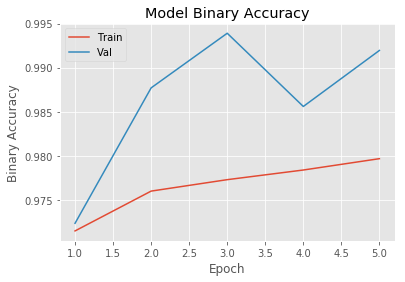

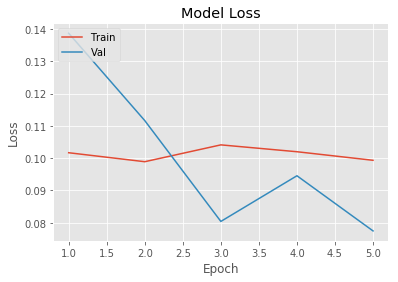

In [45]:
plot_learningCurve(standardized_smote_fit,num_epochs)

In [46]:
# save nornalized imbalanced_ann model
# serialize model to JSON
with open("models/standardized_smote_balaned_ann_fraud_detector.json", "w") as json_file:
    json_file.write(smote_ann.to_json())
# serialize weights to HDF5
smote_ann.save_weights("models/standardized_smote_balaned_ann_fraud_detector.h5")

In [47]:
filepath="models/normalized-smote-balanced-ann-weights-improvement-{epoch:02d}-{val_"+metric+":.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
callbacks_list_minmax_smote_balanced_ann = [checkpoint]

In [ ]:
minmax_smote_ann=keras.models.clone_model(smote_ann)
minmax_smote_ann.compile(loss=loss_function,optimizer=optimization_function,metrics=[metric])
minmax_smote_fit=minmax_smote_ann.fit(minmax_x_train_sm,minmax_y_train_sm,
                                      callbacks=callbacks_list_minmax_smote_balanced_ann,
                                      batch_size=batch_bin,epochs=num_epochs,validation_split=validate_pct)

Train on 8133632 samples, validate on 2033408 samples
Epoch 1/5
8133312/8133632 [============================>.] - ETA: 0s - loss: 0.1199 - binary_accuracy: 0.9748- ETA: 
Epoch 00001: val_binary_accuracy improved from -inf to 0.99536, saving model to models/normalized-smote-balanced-ann-weights-improvement-01-1.00.hdf5
8133632/8133632 [==============================] - 912s 112us/sample - loss: 0.1199 - binary_accuracy: 0.9748 - val_loss: 0.1139 - val_binary_accuracy: 0.9954
Epoch 2/5
3695776/8133632 [============>.................] - ETA: 7:05 - loss: 0.0962 - binary_accuracy: 0.9849

In [37]:
standardized_smote_y_pred = smote_ann.predict_classes(standard_x_test)

In [42]:
print_confusion_matrix(y_test,standardized_smote_y_pred)

Percent of true positives: 98.84%
Percent of false negatives: 1.16%
Percent of true negatives: 98.00%
Percent of false positives: 2.00%


,Pred Fraud,Pred Non-Fraud
Actual Fraud,1618,19
Actual Non-Fraud,25444,1245443


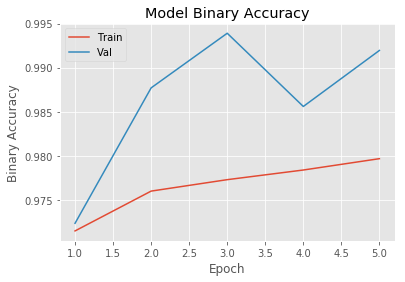

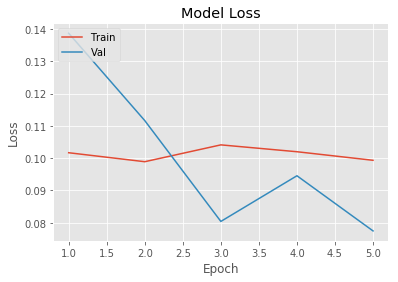

In [45]:
plot_learningCurve(standardized_smote_fit,num_epochs)

In [46]:
# save nornalized imbalanced_ann model
# serialize model to JSON
with open("models/standardized_smote_balaned_ann_fraud_detector.json", "w") as json_file:
    json_file.write(smote_ann.to_json())
# serialize weights to HDF5
smote_ann.save_weights("models/standardized_smote_balaned_ann_fraud_detector.h5")

### Autoencoder Neural Network

In [28]:
autoencoder = Sequential()

autoencoder.add(InputLayer(input_shape=(11,)))
autoencoder.add(Dense(32,activation='relu', activity_regularizer=regularizers.l1(learning_rate)))
autoencoder.add(Dense(6,activation='relu'))
autoencoder.add(Dense(6,activation='relu'))
autoencoder.add(Dense(32,activation='relu'))
autoencoder.add(Dense(11,activation='linear'))

In [29]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_4 (Dense)              (None, 11)                363       
Total params: 1,211
Trainable params: 1,211
Non-trainable params: 0
_________________________________________________________________


In [40]:
autoencoder.compile(metrics=['accuracy'],loss='mean_squared_error',optimizer='adam')

In [46]:
filepath="models/standardized-autoencoder-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list_standard_autoencoder = [checkpoint]

In [57]:
standard_fit_ae = autoencoder.fit(standard_x_train_ae,standard_x_train_ae,
                                  callbacks=callbacks_list_standard_autoencoder,
                                  batch_size=batch_bin,shuffle=True,epochs=5,validation_split=0.2)

Train on 4066820 samples, validate on 1016705 samples
Epoch 1/5
4066816/4066820 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9890
Epoch 00001: val_accuracy improved from 0.94901 to 0.99549, saving model to models/standard-autoencoder-weights-improvement-01-1.00.hdf5
4066820/4066820 [==============================] - 389s 96us/sample - loss: 0.0057 - accuracy: 0.9890 - val_loss: 0.0023 - val_accuracy: 0.9955
Epoch 2/5
4066272/4066820 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9948
Epoch 00002: val_accuracy did not improve from 0.99549
4066820/4066820 [==============================] - 395s 97us/sample - loss: 0.0022 - accuracy: 0.9948 - val_loss: 0.0019 - val_accuracy: 0.9934
Epoch 3/5
4066240/4066820 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 0.9950
Epoch 00003: val_accuracy did not improve from 0.99549
4066820/4066820 [==============================] - 408s 100us/sample - loss: 0.0019 - accuracy: 0.9950

In [59]:
standardized_autoencoder_y_pred = autoencoder.predict_classes(standard_x_test_ae)

In [63]:
print_confusion_matrix(y_test_ae,standardized_autoencoder_x_pred)

Percent of true positives: nan%
Percent of false negatives: nan%
Percent of true negatives: 88.98%
Percent of false positives: 11.02%


C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys


,Pred Fraud,Pred Non-Fraud
Actual Fraud,0,0
Actual Non-Fraud,7193,58056


In [1]:
plot_learningCurve(standard_fit_ae,num_epochs)

NameError: name 'plot_learningCurve' is not defined

In [ ]:
# save nornalized imbalanced_ann model
# serialize model to JSON
with open("models/standardized_autoencoder.json", "w") as json_file:
    json_file.write(autoencoder.to_json())
# serialize weights to HDF5
autoencoder.save_weights("models/standardized_autoencoder.h5")